## Genetic compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.genetic import GeneticController
from utils.plot import *

Setting some global parameters (for the genetic search settings look in `utils.genetic_config.py`)

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 1
CR_MULTIPLIER = 1.5

NUM_GENERATIONS = 36
NUM_PULATION = 12

SAVE_EVOL_FILE = './results/test_GA_save.csv'
SAVE_EVERY = 1

RANGE_OPTIMIZATION = True

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]

def fitness_fc(individual):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    for layer in ws_controller.model_layers:
        layer.weight.requires_grad = True
    
    # share weigts by chromosome
    individual.data = ws_controller.share(individual.chromosome, share_order, retrain_amount)

    if individual.data['accuracy'] <= 0.95:
        #return ACC_MULTIPLIER * individual.data['accuracy']
        #return ACC_MULTIPLIER * math.log(1/(1 - individual.data['accuracy']))
        return individual.data['accuracy']

    #return ACC_MULTIPLIER * individual.data['accuracy'] + CR_MULTIPLIER * math.log(individual.data['compression'])
    #return ACC_MULTIPLIER * math.log(1/(1 - individual.data['accuracy'])) + CR_MULTIPLIER * math.log(individual.data['compression'])
    #return math.log(1/(1 - individual.data['accuracy'])) * math.log(individual.data['compression'])
    #return math.sqrt(1/(1 - individual.data['accuracy'])) + math.sqrt(individual.data['compression'])
    #return individual.data['accuracy'] + (individual.data['compression'] / 32)

    return 1 / math.sqrt(pow(1 - ((individual.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (individual.data['compression']/14), 2))


Defining logging function and elit dealing function

In [6]:
data = {
    'generation': [],
    'fitness': [],
    'chromosome': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'generation' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

evol_data = pd.read_csv(SAVE_EVOL_FILE).astype(data_types) if os.path.exists(SAVE_EVOL_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(gen_cont:GeneticController):
    global evol_data

    new_data = copy.deepcopy(data)

    for indiv in gen_cont.population:

        new_data['generation'].append(gen_cont.generation)
        new_data['fitness'].append(indiv.fitness)
        new_data['chromosome'].append(indiv.chromosome)
        new_data['accuracy'].append(indiv.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
        new_data['compression'].append(indiv.data['compression'])
        new_data['share_t'].append(indiv.data['times']['share'])
        new_data['train_t'].append(indiv.data['times']['train'])
        new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    evol_data = evol_data.append(pd.DataFrame(new_data).astype(data_types))
    if gen_cont.generation % SAVE_EVERY == SAVE_EVERY - 1:
        evol_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_EVOL_FILE), exist_ok=True)
        evol_data.to_csv(SAVE_EVOL_FILE, index=False)
    
def deal_elit(population):
    for individual in population:
        if individual.data is not None:
            individual.data['times'] = {
                'share': 0,
                'train': 0,
                'test': 0
            }


Setting ranges with optimization

In [7]:
chromosome_ranges = [range(1, 51), range(1, 51), range(1, 51), range(1, 51), range(1, 51)]

lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    chromosome_ranges = ws_controller.get_optimized_layer_ranges(chromosome_ranges, lam_test_inp, 0.97, savefile='./results/lenet-layer-perf.csv')

chromosome_ranges

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Run evolution

In [8]:
genetic = GeneticController(chromosome_ranges, NUM_PULATION, fitness_fc)

if evol_data.size != 0:
    genetic.load_from_pd(evol_data)

genetic.run(NUM_GENERATIONS, logger_fc, deal_elit=deal_elit, verbose=True)

Generation 1/36 (1) evaluated, best fitness 2.153069689782954
Generation 2/36 (2) evaluated, best fitness 2.2456230691310513
Generation 3/36 (3) evaluated, best fitness 2.4111130640083287
Generation 4/36 (4) evaluated, best fitness 2.556982341750167
Generation 5/36 (5) evaluated, best fitness 2.556982341750167
Generation 6/36 (6) evaluated, best fitness 2.556982341750167
Generation 7/36 (7) evaluated, best fitness 2.556982341750167
Generation 8/36 (8) evaluated, best fitness 2.6551313472128704
Generation 9/36 (9) evaluated, best fitness 2.6551313472128704
Generation 10/36 (10) evaluated, best fitness 2.6551313472128704
Generation 11/36 (11) evaluated, best fitness 2.6551313472128704
Generation 12/36 (12) evaluated, best fitness 2.6737329027693724
Generation 13/36 (13) evaluated, best fitness 3.3114561314163016
Generation 14/36 (14) evaluated, best fitness 3.3114561314163016
Generation 15/36 (15) evaluated, best fitness 3.3114561314163016
Generation 16/36 (16) evaluated, best fitness 3.

[2, 19, 30, 12, 4]

See output

In [9]:
evol_data

,generation,fitness,chromosome,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,2.153070,"[2, 42, 18, 47, 36]",0.9746,0.0100,8.556165,1.178918,0.0,3.553911
1,0,1.825001,"[5, 28, 5, 46, 32]",0.9796,0.0050,6.880237,0.736323,0.0,3.726575
2,0,1.727398,"[47, 7, 40, 25, 13]",0.9858,-0.0012,6.142925,1.489286,0.0,3.570318
3,0,1.674239,"[44, 32, 31, 8, 26]",0.9834,0.0012,5.967429,1.270665,0.0,3.583757
4,0,1.672780,"[21, 10, 33, 5, 42]",0.9790,0.0056,6.164080,1.307698,0.0,3.802925
...,...,...,...,...,...,...,...,...,...
427,35,2.069299,"[23, 19, 32, 12, 4]",0.9838,0.0008,7.625896,1.194742,0.0,4.053983
428,35,2.005316,"[33, 28, 28, 3, 5]",0.9736,0.0110,8.077152,1.208341,0.0,3.964821
429,35,1.776211,"[22, 13, 33, 27, 5]",0.9838,0.0008,6.451406,1.321436,0.0,3.564324
430,35,1.672028,"[33, 7, 29, 42, 22]",0.9850,-0.0004,5.894555,1.376010,0.0,4.415522


Plotting data

Text(0.5, 1.0, 'Genetic Algorithm on LeNet-5')

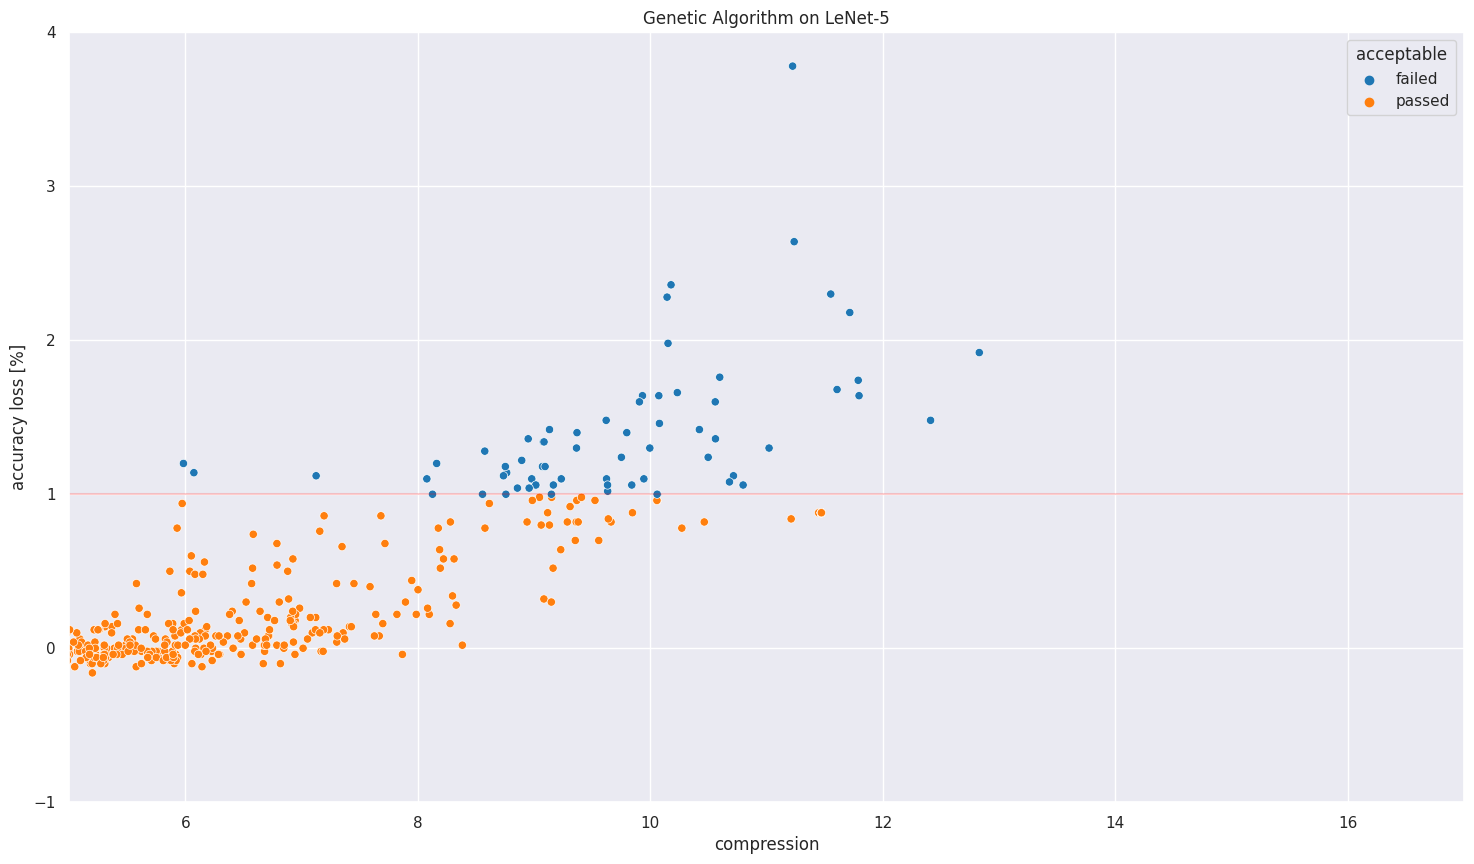

In [10]:
plot_alcr(evol_data)
plt.title('Genetic Algorithm on LeNet-5')